In [10]:
import argparse
import math
import os
from heapq import heappush, heappop, heappushpop

import matplotlib.pyplot as plotter
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import Image 

from utils.ens import *

In [11]:
pd.set_option("display.width", 180)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load Data

In [12]:
path = './data/csvs'
gt_path = './data'

In [19]:
# Ground truth
gt = pd.read_json(os.path.join(gt_path, 'dev_seen.jsonl'), lines=True)
dev_or = {'Correct': gt}

dev, ts, tu = {}, {}, {}
print('Loading data:')
for csv in sorted(os.listdir(path)):
    if ".csv" in csv:
        print(csv)
        name = csv.split('_')[0]
        if ("dev" in csv) or ("val" in csv):
            dev[name] = pd.read_csv(os.path.join(path, csv))
            dev_idx = dev[name].id.values
        elif "test_unseen" in csv:
            tu[name] = pd.read_csv(os.path.join(path, csv))
            tu_idx = tu[name].id.values
        elif "test_seen" in csv:
            ts[name] = pd.read_csv(os.path.join(path, csv))
            ts_idx = ts[name].id.values

dev_or.update(dev)
dev_probas = pd.DataFrame({k: v.proba.values for k, v in dev.items()})
#dev_probas.set_index(dev_idx, inplace=True)
ts_probas = pd.DataFrame({k: v.proba.values for k, v in ts.items()})
#test_seen_probas.set_index(ts_idx, inplace=True)
tu_probas = pd.DataFrame({k: v.proba.values for k, v in tu.items()})
#test_unseen_probas.set_index(tu_idx, inplace=True)

Loading data:
O36_dev_seen.csv
O36_test_seen.csv
O36_test_unseen.csv
O50_dev_seen.csv
O50_test_seen.csv
O50_test_unseen.csv
OV50_dev_seen.csv
OV50_test_seen.csv
OV50_test_unseen.csv
U36_dev_seen.csv
U36_test_seen.csv
U36_test_unseen.csv
U50_dev_seen.csv
U50_test_seen.csv
U50_test_unseen.csv
U72_dev_seen.csv
U72_test_seen.csv
U72_test_unseen.csv
V135_dev_seen.csv
V135_test_seen.csv
V135_test_unseen.csv
V45_dev_seen.csv
V45_test_seen.csv
V45_test_unseen.csv
V90_dev_seen.csv
V90_test_seen.csv
V90_test_unseen.csv


## Utils

In [20]:
def average(data, weights=None):
    N = data.shape[1]
    if weights is None:
        weights = [1/N] * N
    elif np.sum(weights) != 1.:
        weights = weights / np.sum(weights)
    
    # Compute weighted avg
    return data.apply(lambda row: row.multiply(weights).sum(), axis=1)

In [21]:
def acc_from_roc(labels, probas, splits=None):
    '''Determines the greatest achievable accuracy from the ROC curve.'''
    if splits is None:
        splits = (250, 250)

    fpr, tpr, thresholds = roc_curve(labels, probas)
    tp = tpr * splits[0]
    tn = (1 - fpr) * splits[1]
    acc = (tp + tn) / np.sum(splits)
    best_threshold = thresholds[np.argmax(acc)]

    return np.amax(acc), best_threshold

## Main Loop

In [22]:
loop, last_score, delta = 0, 0, 0.1

while delta > 0.0001:

    # Individual AUROCs
    print('\n' + '-' * 21 , 'ROUND ' + str(loop) , '-' * 21)
    print("Individual AUROCs for Validation Sets:\n")
    for i, column in enumerate(dev_probas):   
        score = roc_auc_score(gt.label, dev_probas.iloc[:, i])
        print(column, score)

    # Drop worst performing sets
    if loop > 0:
        print('\n' + '-' * 50)
        scores = dev_probas.apply(lambda col: roc_auc_score(gt.label, col), result_type='reduce')
        while len(scores) > 5:
            worst = scores.idxmin()
            #del dev[worst]
            dev_probas.drop(worst, axis=1, inplace=True)
            ts_probas.drop(worst, axis=1, inplace=True)
            tu_probas.drop(worst, axis=1, inplace=True)
            scores.drop(worst, inplace=True)
            print("Dropped:", worst)

    # Spearman Correlations:
    print('\n' + '-' * 50)
    print("Spearman Corrs:")
    dev_corr = dev_probas.corr(method='spearman')
    test_seen_corr = ts_probas.corr(method='spearman')
    test_unseen_corr = tu_probas.corr(method='spearman')

    print('\n', dev_corr)
    print('\n', test_seen_corr)
    print('\n', test_unseen_corr)
    print('\n' + '-' * 50)

    # Simple
    print('Simple:')
    weights_dev = Simplex(dev_probas, gt.label)
    dev_probas[f'SX_{loop}'] = average(dev_probas, weights=weights_dev)
    ts_probas[f'SX_{loop}'] = average(ts_probas, weights=weights_dev)
    tu_probas[f'SX_{loop}'] = average(tu_probas, weights=weights_dev)
    score = roc_auc_score(gt.label, dev_probas[f'SX_{loop}'])
    print(f"AUROC: {score:.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'SX_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Arithmetic Mean
    print('Arithmetic Mean:')
    dev_probas[f'AM_{loop}'] = average(dev_probas.apply(np.exp)).apply(np.log)
    ts_probas[f'AM_{loop}'] = average(ts_probas.apply(np.exp)).apply(np.log)
    tu_probas[f'AM_{loop}'] = average(tu_probas.apply(np.exp)).apply(np.log)
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'AM_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'AM_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Geometric Mean (remain in logspace)
    print('Geometric Mean:')
    dev_probas[f'GM_{loop}'] = average(dev_probas)
    ts_probas[f'GM_{loop}'] = average(ts_probas)
    tu_probas[f'GM_{loop}'] = average(tu_probas)
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'GM_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'GM_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)

    # TODO: Power Average
    '''
    print('Power Average:')
    dev_PA = simple_average(dev_probas, dev[0], power=2, normalize=True)
    test_PA = simple_average(test_probas, test[0], power=2, normalize=True)
    test_unseen_PA = simple_average(test_unseen_probas, test_unseen[0], power=2, normalize=True)
    print(roc_auc_score(dev_df.label, dev_PA.proba), accuracy_score(dev_df.label, dev_PA.label))
    print('\n' + '-' * 50)
    '''
    
    # Rank Average
    print('Rank Average:')
    dev_probas[f'RA_{loop}'] = average(dev_probas.apply(lambda col: rankdata(col) / len(col)))
    ts_probas[f'RA_{loop}'] = average(ts_probas.apply(lambda col: rankdata(col) / len(col)))
    tu_probas[f'RA_{loop}'] = average(tu_probas.apply(lambda col: rankdata(col) / len(col)))
    print(f"AUROC: {roc_auc_score(gt.label, dev_probas[f'RA_{loop}']):.4f}")
    print(f"Accuracy: {acc_from_roc(gt.label, dev_probas[f'RA_{loop}'])[0]:.4f}")
    print('\n' + '-' * 50)
    
    # Calculate Delta & increment loop
    delta = abs(score - last_score)
    last_score = score

    loop += 1

    print("Currently at {} after {} loops.".format(last_score, loop))

dev_best = dev_probas[f'SX_{loop-1}']
ts_best = ts_probas[f'SX_{loop-1}']
tu_best = tu_probas[f'SX_{loop-1}']
print("Finished!")


--------------------- ROUND 0 ---------------------
Individual AUROCs for Validation Sets:

O36 0.760349490326607
O50 0.7505720823798627
OV50 0.7582931942199678
U36 0.770694980077131
U50 0.7680385975580484
U72 0.7505160743147015
V135 0.7526203773343361
V45 0.7463314717319294
V90 0.761453649325503

--------------------------------------------------
Spearman Corrs:

          O36     O50    OV50     U36     U50     U72    V135     V45     V90
O36  1.00000 0.87911 0.90306 0.78688 0.79070 0.75142 0.69522 0.70245 0.72411
O50  0.87911 1.00000 0.83560 0.77431 0.77570 0.73142 0.69021 0.70358 0.73218
OV50 0.90306 0.83560 1.00000 0.78152 0.78879 0.76062 0.68087 0.68897 0.70826
U36  0.78688 0.77431 0.78152 1.00000 0.87483 0.84955 0.70279 0.70377 0.71903
U50  0.79070 0.77570 0.78879 0.87483 1.00000 0.84481 0.65211 0.66427 0.67597
U72  0.75142 0.73142 0.76062 0.84955 0.84481 1.00000 0.65628 0.67307 0.67086
V135 0.69522 0.69021 0.68087 0.70279 0.65211 0.65628 1.00000 0.94063 0.93395
V45  0.70245 0.

## Dump Output

In [23]:
experiment = 'OVUfull'

In [24]:
 # Get accuracy thresholds & optimize (This does not add value to the roc auc, but just to also have an acc score)
acc, threshold = acc_from_roc(gt.label, dev_best)

# As Simplex at some point simply weighs the highest of all - lets take sx as the final prediction after x loops
dev_labels = dev_best.apply(lambda x: 1 if x > threshold else 0)
dev_out = pd.DataFrame({'id': dev_idx, 'proba': dev_best, 'label': dev_labels})
ts_labels = ts_best.apply(lambda x: 1 if x > threshold else 0)
ts_out = pd.DataFrame({'id': ts_idx, 'proba': ts_best, 'label': ts_labels})
tu_labels = tu_best.apply(lambda x: 1 if x > threshold else 0)
tu_out = pd.DataFrame({'id': tu_idx, 'proba': tu_best, 'label': tu_labels})
ts_out.to_csv(os.path.join(path, f"final/FIN_test_seen_{experiment}_{loop}.csv"), index=False)
tu_out.to_csv(os.path.join(path, f"final/FIN_test_unseen_{experiment}_{loop}.csv"), index=False)

In [25]:
threshold

-3.3821073932820993

## Model Comparison

In [26]:
dev_labels = pd.DataFrame({k: v.label.values for k, v in dev_or.items()})
dev_labels['Ensemble'] = dev_out.label.values
dev_labels.set_index(dev_idx, inplace=True)
dev_labels

,Correct,O36,O50,OV50,U36,U50,U72,V135,V45,V90,Ensemble
8291,1,0,0,0,1,1,0,0,0,0,1
46971,1,0,0,0,0,0,0,0,0,0,0
3745,1,0,0,1,0,0,0,0,0,0,0
83745,1,0,0,0,0,0,0,0,0,0,0
80243,1,1,1,1,1,1,1,1,1,1,1
5279,1,1,0,1,1,1,1,1,1,1,1
1796,1,1,0,1,1,0,0,0,0,0,1
53046,1,0,0,0,0,0,0,0,0,0,0
82301,1,0,0,0,0,0,0,0,0,0,0
31752,1,1,0,0,1,1,1,1,1,1,1


In [27]:
compare = pd.DataFrame({k: v.proba.values for k, v in dev_or.items() if k != 'Correct'})
compare['EnsProb'] = dev_out.proba.values
compare['EnsHard'] = dev_out.label.values
compare['Correct'] = gt.label.values
full_idx = gt.img.apply(lambda x: x[4:-4]).values
compare.set_index(full_idx, inplace=True)
compare

,O36,O50,OV50,U36,U50,U72,V135,V45,V90,EnsProb,EnsHard,Correct
08291,-6.55335,-6.53633,-5.76158,-0.00111,-0.00426,-8.70919,-0.98961,-3.01301,-1.54177,-0.70697,1,1
46971,-5.62325,-7.29344,-5.42926,-8.49530,-7.66392,-5.69055,-6.91194,-5.56828,-6.69390,-5.00647,0,1
03745,-1.62587,-6.44291,-0.00284,-8.25349,-7.08087,-6.84180,-6.75343,-1.01262,-5.39089,-4.20012,0,1
83745,-4.52095,-7.51713,-6.28461,-8.39967,-8.97850,-9.64303,-1.39287,-1.40441,-0.88640,-4.36602,0,1
80243,-0.00019,-0.00092,-0.00028,-0.00018,-0.00060,-0.00025,-0.00795,-0.00093,-0.01726,0.30003,1,1
05279,-0.25379,-2.54499,-0.15073,-0.00145,-0.00091,-0.00023,-0.00095,-0.01647,-0.00631,0.23579,1,1
01796,-0.32032,-2.78075,-0.00469,-0.01652,-8.02665,-10.49943,-4.93600,-2.95018,-4.77367,-0.90307,1,1
53046,-7.95081,-8.24694,-6.96462,-8.64019,-8.76597,-9.65660,-13.38698,-12.29343,-12.01585,-6.12775,0,1
82301,-7.86709,-8.35596,-6.25118,-8.15950,-8.28559,-9.16040,-8.34159,-8.55588,-8.69322,-5.35263,0,1
31752,-0.05004,-6.34721,-0.78928,-0.00471,-0.12734,-0.17711,-0.20082,-0.08483,-0.14206,0.14642,1,1


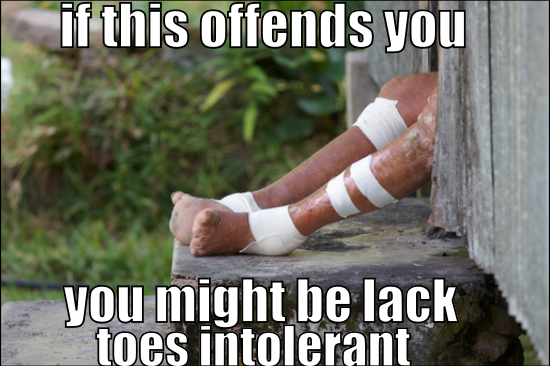

In [29]:
img = Image(filename='data/img/25149.png')
display(img)

In [30]:
diff = compare['Correct'] - compare['EnsHard']
fns = compare[diff == 1]
fps = compare[diff == -1] 
print(f'{len(fns)} false negatives, {len(fps)} false positives')

78 false negatives, 62 false positives


In [104]:
fps

,O365050,U365072,VLMDB,EnsProb,EnsHard,Correct
91405,-0.78686,-0.05040,-0.61231,-0.25054,1,0
97453,-3.57056,-0.00172,-1.26180,-0.77062,1,0
32875,-3.24371,-3.77994,-1.08091,-3.31967,1,0
30579,-0.00394,-2.46973,-0.00068,-1.71891,1,0
62504,-0.48459,-2.14401,-0.02494,-1.57589,1,0
37420,-0.36479,-4.85556,-7.12117,-4.41704,1,0
82509,-3.55717,-4.88441,-2.08253,-4.27796,1,0
03214,-4.91847,-1.65513,-6.66313,-2.88786,1,0
91058,-4.86338,-5.85705,-2.73527,-5.26234,1,0
19523,-6.77174,-3.52367,-1.17245,-3.74297,1,0


In [109]:
fns

,O365050,U365072,VLMDB,EnsProb,EnsHard,Correct
46971,-6.14780,-7.80910,-7.29697,-7.46140,0,1
83745,-7.06995,-7.95759,-1.09599,-6.86687,0,1
53046,-8.01558,-7.95596,-11.96311,-8.51635,0,1
82301,-7.72542,-7.69864,-8.35958,-7.79390,0,1
25149,-4.96200,-7.83398,-8.54562,-7.45226,0,1
02568,-3.51565,-7.46948,-4.11726,-6.34892,0,1
62035,-8.61059,-8.18156,-8.04913,-8.23499,0,1
92058,-7.14905,-7.18954,-1.98810,-6.46830,0,1
87130,-7.13560,-7.54483,-3.61640,-6.93689,0,1
47819,-6.59049,-7.33942,-9.06400,-7.45128,0,1
